# Configuration and Intercomparison of Deep Learning Neural Models for Statistical Downscaling 
### *Submitted to Geoscientific Model Development (September 2019)*
### J. Baño-Medina, R. Manzanas and J. M. Gutiérrez

This notebook is part of the companion material to the manuscript entitled *Configuration and Intercomparison of Deep Learning Neural Models for Statistical Downscaling* by *J. Baño-Medina, R. Manzanas and J. M. Gutiérrez*, which has been submitted for discussion to *Geoscientific Model Development* in September 2019. In order to increase research transparency, this document allows to reproduce the results presented in the mentioned paper for one of the analysis undertaken there, the prediction of temperature with a convolutional neural network (CNN hereafter) with 10 feature maps. Note however that the full code needed to reproduce the rest of experiments presented in the paper (including the user of other architectures, standard bencmarking methods and also resutls for precipitation) can be found in [GitHub](https://github.com/SantanderMetGroup/DeepDownscaling). 

**Note:** This notebook (and the rest of the code delivered with the paper via [GitHub](https://github.com/SantanderMetGroup/DeepDownscaling)) is written in the free programming language `R`, which has been increasingly used by data miners and climate scientits during the last years. Moreover, a great part of the code relies on [climate4R](https://github.com/SantanderMetGroup/climate4R) (C4R hereafter), a suite of `R` packages developed by the [Santander Met Group](http://meteo.unican.es) for transparent climate data access, post processing (including bias correction and downscaling) and visualization. The interested reader is referred to [Iturbide et al. 2019](https://www.sciencedirect.com/science/article/pii/S1364815218303049?via%3Dihub) for further details on C4R.

# Setting working environment
First of all, we define the directory in which the data, models and figures that we are going to create will be saved.

In [1]:
wd = "/climate/CNN"  # working directory (choose your preferred location)
var = "temperature"  # variable of interest (just a label)

## output directories
dir.data = paste0(wd, "/data/", var)
dir.create(dir.data, recursive = TRUE, showWarnings = FALSE)
dir.models = paste0(wd, "/models/", var)
dir.create(dir.models, recursive = TRUE, showWarnings = FALSE)
dir.figs = paste0(wd, "/figs/", var)
dir.create(dir.figs, recursive = TRUE, showWarnings = FALSE)

# Loading and preparing the data
We need now to load the climate data which will be used hereafter, both the predictors and the precictand. As explained in the paper, we have considered 20 large-scale variables from the ERA-Interim reanalysis as predictors and surface temperature from E-OBS as predictand. All these data can be loaded from the User Data Getaway-Thredds Access Portal ([UDG-TAP](http://meteo.unican.es/udg-tap/home)) from the Santander Met Group, which provides access to various kinds of climate datasets (global and regional climate models, reanalysis, observations...). We will use the `loadGridData` from the [`loadeR`](https://github.com/SantanderMetGroup/loadeR) package (included in C4R) to read the data. The package [`transformeR`](https://github.com/SantanderMetGroup/transformeR) (included in C4R) will be also needed to perform basic operations (data splitting, collocation, etc.) on the C4R grid objects.

**Note:** A registered user in the UDG-TAP is needed to run this step (registration can be done [here](http://meteo.unican.es/udg-tap/signup)).

In [6]:
library(loadeR)  # package containing the function "loadGridData"
loginUDG(username = "", password = "")  # to access the datasets it is first needed to log into the UDG-TAP
library(transformeR)  # package to perform basic operations on C4R grid objects
library(magrittr)  # this library is useful to simplify the code syntax

Loading required package: rJava
Loading required package: loadeR.java
Java version 11x amd64 by Ubuntu detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
loadeR version 1.4.15 (2019-07-30) is loaded
Please use 'citation("loadeR")' to cite this package.
[2019-09-25 21:45:19] Setting credentials...
[2019-09-25 21:45:19] Success!
Go to <http://www.meteo.unican.es/udg-tap/home> for details on your authorized groups and datasets
transformeR version 1.5.1 (2019-07-13) is loaded
Please see 'citation("transformeR")' to cite this package.


### Loading predictors

In [11]:
## --- the next chunk of code takes about 5 minutes to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## loading predictor variables from ERA-Interim
variables <- c("z@500","z@700","z@850","z@1000",  
               "hus@500","hus@700","hus@850","hus@1000",
               "ta@500","ta@700","ta@850","ta@1000",
               "ua@500","ua@700","ua@850","ua@1000",
               "va@500","va@700","va@850","va@1000")
x <- lapply(variables, function(x) {
  loadGridData(dataset = "ECMWF_ERA-Interim-ESD",
               var = x,
               lonLim = c(-10, 32), # longitude domain: 22 gridboxes (2º resolution)
               latLim = c(36, 72),  # latitude domain: 19 gridboxes (2º resolution)
               years = 1979:2008)  # total period of study
}) %>% makeMultiGrid() %>% redim(, drop = T)
## saving predictor data
save(x, file = paste0(dir.data, "/x.rda"))  

NOTE: Accessing harmonized data from a public UDG dataset
[2019-09-24 20:11:33] Defining harmonization parameters for variable "z@500"
[2019-09-24 20:11:33] Opening dataset...
[2019-09-24 20:11:34] The dataset was successfuly opened
[2019-09-24 20:11:34] Defining geo-location parameters
[2019-09-24 20:11:35] Defining time selection parameters
[2019-09-24 20:11:35] Retrieving data subset ...
[2019-09-24 20:11:50] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-09-24 20:11:50] Defining harmonization parameters for variable "z@700"
[2019-09-24 20:11:50] Opening dataset...
[2019-09-24 20:11:50] The dataset was successfuly opened
[2019-09-24 20:11:51] Defining geo-location parameters
[2019-09-24 20:11:51] Defining time selection parameters
[2019-09-24 20:11:51] Retrieving data subset ...
[2019-09-24 20:12:07] Done
NOTE: Accessing harmonized data from a public UDG dataset
[2019-09-24 20:12:07] Defining harmonization parameters for variable "z@850"
[2019-09-24 20:12:07] O

### Loading predictand

In [12]:
## --- the next chunk of code takes about 1 minute to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

# loading predictand (temperature), from E-OBS
y <- loadGridData(dataset = "E-OBS_v14_0.50regular",
                   var = "tas",
                   lonLim = c(-10, 32), # longitude domain: 85 gridboxes (0.5º resolution)
                   latLim = c(36, 72),  # latitude domain: 73 gridboxes (0.5º resolution)
                   years = 1979:2008)  # total period of study
# saving predictand data
save(y, file = paste0(dir.data, "/y.rda"))  

NOTE: Accessing harmonized data from a public UDG dataset
[2019-09-24 20:19:05] Defining harmonization parameters for variable "tas"
[2019-09-24 20:19:05] Opening dataset...
[2019-09-24 20:19:05] The dataset was successfuly opened
[2019-09-24 20:19:05] Defining geo-location parameters
[2019-09-24 20:19:05] Defining time selection parameters
[2019-09-24 20:19:06] Retrieving data subset ...
[2019-09-24 20:20:02] Done


### Train/test partition
As in the paper, we split the entire period of study into *train* (1979-2002) and *test* (2003-2008). To do that, we use the `subsetGrid` function from `transformeR`.

In [5]:
## predictor and predictand data for the train period
xT <- subsetGrid(x, years = 1979:2002)
yT <- subsetGrid(y, years = 1979:2002)

## predictor and predictand data for the test period
xt <- subsetGrid(x ,years = 2003:2008)
yt <- subsetGrid(y ,years = 2003:2008)

rm(x, y)  # to save memory

### Data standardization
The predictors are then standardized at a gridbox level using the function `scaleGrid` (also from `transformeR`).

In [6]:
## standardazing predictor data
xt <- scaleGrid(xt, xT, type = "standardize", spatial.frame = "gridbox") %>% redim(drop = TRUE)  # test period: standardization is done with respect to the train period
xT <- scaleGrid(xT, type = "standardize", spatial.frame = "gridbox") %>% redim(drop = TRUE)  # train period

[2019-09-25 21:49:38] - Scaling ...
[2019-09-25 21:49:51] - Done
[2019-09-25 21:49:51] - Scaling ...
[2019-09-25 21:50:05] - Done


# Downscaling
Once the predictors and the predictand are loaded, we can start the downscaling process. In this example we will use the [`keras`](https://cran.r-project.org/web/packages/keras/index.html) library, which provides an `R` interface to [Keras](https://keras.io), a high-level neural networks API which supports arbitrary network architectures and is seamlessly integrated with [TensorFlow](https://www.tensorflow.org/) (note that Keras and TensorFlow are the state of the art in deep learning tools).

In [9]:
library(keras)  # loading keras

For simplicity, we define an auxiliary function called `C4RKeras` which converts our climate data (C4R grid objects) to the format required to easily work with `keras`. In particular, this function discards all the gridboxes over the sea in the E-OBS dataset, for which there are no data; and also those land points for which some missing data is present (`keras` does not support missing values).

In [11]:
# auxiliary function to convert C4R data to the format required by keras
C4R2Keras <- function(x, y) {
  xx <- x$Data
  xx <- xx %>% aperm(c(2,3,4,1))  # time*lat*lon*var (for convenience when using Keras built-in functions)
  yy <- y$Data
  dim(yy) <- c(dim(yy)[1], dim(yy)[2]*dim(yy)[3])
  indLand <- (!apply(yy, MARGIN = 2, anyNA)) %>% which()
  yy <- yy[, indLand]  # keeping only land points with no missing values
  
  data.Keras = list()
  data.Keras$x = xx
  data.Keras$y = yy
  return(data.Keras)
}

### Network architecture
Next, we use `keras` to define the architecture of our network (labelled as CNN10 in the paper; see Table 2). This network includes a first block of three convolutional layers with 50, 25 and 10 (3 x 3 x number of inputs coming from the previous layer) kernels, respectively, followed by two fully-connected (dense) layers with 50 neurons each. In the hidden layers, the *ReLu* activation function is used, and padding is considered.

In [12]:
## defining the network architecture in keras
architecture = "CNN10"  # just a label
callbacks <- list(callback_early_stopping(patience = 30),  # we fix patience = 30 (based on empirical screening)
                  callback_model_checkpoint(filepath = paste0(dir.models, "/", architecture, ".h5"),
                                            monitor = 'val_loss', save_best_only = TRUE)  # we save only the best model (the one with the smallest validation error)
)

dataT.Keras <- C4R2Keras(xT, yT)  # predictor and predictand data for the train period
inputs <- layer_input(shape = dim(dataT.Keras$x)[-1])  # inputs
l1 = layer_conv_2d(inputs, filters = 50, kernel_size = c(3, 3), activation = 'relu', padding = "valid")   # first layer
l2 = layer_conv_2d(l1, filters = 25, kernel_size = c(3, 3), activation = 'relu', padding = "valid")   # second layer
l3 = layer_conv_2d(l2, filters = 10, kernel_size = c(3, 3), activation = 'relu', padding = "valid")   # third layer
l4 = layer_flatten(l3)  # fourth layer
outputs <- layer_dense(l4, units = ncol(dataT.Keras$y))  # outputs
model <- keras_model(inputs = inputs, outputs = outputs)  # network architecture

### Training the network
We are now in the position to compile and train the network. Note that, in terms of computation, this is the most expensive step (it took 3 hours in the machine used to write this notebook). 
Despite the parameter `epochs` is set to 10000 in the following chunk of code, early-stopping is applied. Therefore, the training ends whenever the error in the validation dataset (10% of the training period, as indicated by `validation_split = 0.1`) stops decreasing.

In [ ]:
## --- the next chunk of code takes about 3 hours to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## compiling and fitting the network in keras (the best model is automatically saved)
model %>% compile(optimizer = optimizer_adam(lr = 0.0001), loss = "mse")   # loss function: "MSE"
model %>% fit(dataT.Keras$x, dataT.Keras$y, epochs = 10000, batch_size = 100, 
              validation_split = 0.1, callbacks = callbacks, verbose = 0)   # set verbose = 1 to monitor the evolution of the traning process
k_clear_session()  # it is important to clear the session right after the model is fitted

## --- stopped at epoch 431, with loss: 0.8510, and val_loss: 1.0944

### Making predictions
Once the network has been successfully trained, we can use it to make our predictions. Before doing so, we create a pair of auxiliary functions, `convert2map2D` and `predictDEEP`. The latter loads the model that thas been previously fitted, makes the predicions and relies on the former to reconstruct these predictions to a 2-D map (in which missing values are treated conveniently), saving thenm as a C4R grid object.

In [14]:
## auxiliary function to convert the predictions returned by keras to a lat/lon regular 2D-grid, filling with NA points for which there are no predictions (e.g. over the sea)
convert2map2D <- function(data, template, templateT) {
  ntime <- dim(template$Data)[1]
  nlat <- dim(template$Data)[2]
  nlon <- dim(template$Data)[3]
  
  data.aux <- templateT$Data
  dim(data.aux) <- c(dim(data.aux)[1], nlat*nlon)
  indLand <- (!apply(data.aux, MARGIN = 2, anyNA)) %>% which()
  indSea <- (apply(data.aux, MARGIN = 2,anyNA)) %>% which()
  
  out <- template
  dim(out$Data) <- c(ntime, nlat*nlon)
  out$Data[, indLand] <- data
  out$Data[, indSea] <- NA
  dim(out$Data) <- c(ntime, nlat, nlon)
  return(out)
}

## auxiliary function used to predict (we define this function for convenience)
predictDEEP <- function(x, template, templateT, architecture, dataset) {
  model <- load_model_hdf5(filepath = paste0(dir.models, "/", architecture, ".h5"))  # loading the model that has been previously saved
  
  pred <- model$predict(C4R2Keras(x, template)$x)  # predictions returned by keras (only for land points with no missing values)
  pred <- convert2map2D(pred, template, templateT)
  
  save(pred,
       file = paste0(dir.data, "/predictions_", dataset, "_", architecture, ".rda"))
  k_clear_session()
}

At this point, we use `predictDEEP` to create and save the predicions for the test period (2003-2008).

In [15]:
## --- the next chunk of code takes about 6 seconds to be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## making predictions for the test period
predictDEEP(xt, template = yt, templateT = yT, architecture = "CNN10", dataset = "test")

# Validation of results
Finally, the predictions which have been just created (and saved) are loaded and validated. Here we focus on the mean error obtained with respect to the observed cimatological value (bias) and the observed extreme percentiles 2th and 98th (biasP02 and biasP98). These metrics are computed using the function `valueMeasure` from the [`climate4R.value`](https://github.com/SantanderMetGroup/climate4R.value) package, a wrapper to the [`VALUE`](https://github.com/SantanderMetGroup/VALUE) package, which was developed in the [COST action VALUE](http://www.value-cost.eu/) for validation purposes. To plot the final maps (comparable to those shown in the bottom row of Figure 5 in the paper) we also need to load the [`visualizeR`](https://github.com/SantanderMetGroup/visualizeR) and `RColorBrewer` packages. If interested in knowing more about the plotting options used here, the reader is referred to the documentation of the `spatialPlot` function.

Loading required package: VALUE
VALUE version 2.1.1 (2019-07-13) is loaded
[2019-09-25 21:51:48] Computing member 1 out of 1
[2019-09-25 21:52:00] Done.
[2019-09-25 21:52:01] Computing member 1 out of 1
[2019-09-25 21:52:13] Done.
[2019-09-25 21:52:14] Computing member 1 out of 1
[2019-09-25 21:52:24] Done.
[2019-09-25 21:52:25] Computing member 1 out of 1
[2019-09-25 21:52:40] Done.
[2019-09-25 21:52:41] Computing member 1 out of 1
[2019-09-25 21:52:55] Done.
[2019-09-25 21:52:56] Computing member 1 out of 1
[2019-09-25 21:53:06] Done.
[2019-09-25 21:53:07] Computing member 1 out of 1
[2019-09-25 21:53:21] Done.
[2019-09-25 21:53:22] Computing member 1 out of 1
[2019-09-25 21:53:36] Done.
[2019-09-25 21:53:37] Computing member 1 out of 1
[2019-09-25 21:53:47] Done.
[2019-09-25 21:53:47] - Computing climatology...
[2019-09-25 21:53:47] - Done.
[2019-09-25 21:53:47] - Computing climatology...
[2019-09-25 21:53:47] - Done.
[2019-09-25 21:53:47] - Computing climatology...
[2019-09-25 21:5

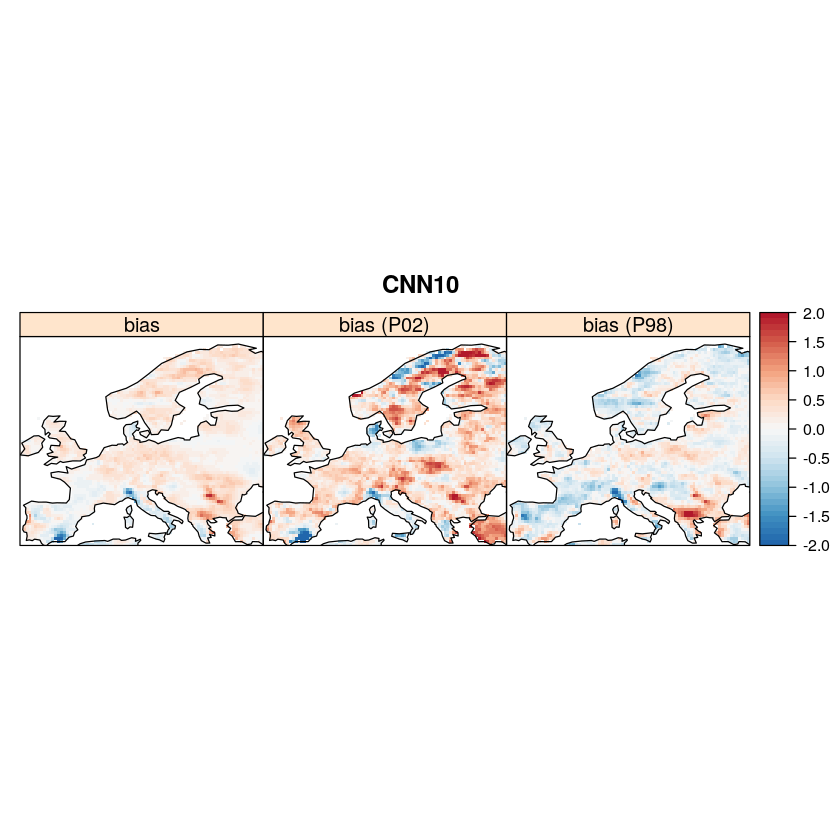

In [16]:
## --- the next chunk of code takes about 2 minutes be completed 
## --- in a personal computer with the technical specifications given at the end of this notebook

## loading packages
library(climate4R.value)
library(visualizeR)
library(RColorBrewer)  # for color palettes

load(paste0(dir.data, "/predictions_test_", architecture, ".rda"))  # loading prediction (previously obtained)

## computing validation metrics
bias <- valueMeasure(yt, pred, measure.code = "bias", index.code = "Mean")$Measure %>% redim()
biasP02 <- valueMeasure(yt, pred, measure.code = "bias", index.code = "P02")$Measure %>% redim()
biasP98 <- valueMeasure(yt, pred, measure.code = "bias", index.code = "P98")$Measure %>% redim()

## producing (and saving) final figure, in pdf format
#pdf(file = paste0(dir.figs, "/", architecture, "_bias_test.pdf"))  # output file. uncomment this line if wants to directly save the figure to a specific location
print(spatialPlot(makeMultiGrid(climatology(bias),
                          climatology(biasP02),
                          climatology(biasP98)),  
            backdrop.theme = "coastline",
            layout = c(3, 1), as.table = T,
            main = architecture,
            names.attr = c("bias", "bias (P02)", "bias (P98)"),
            col.regions = colorRampPalette(rev(brewer.pal(n = 9, "RdBu"))),
            set.min = -2, set.max = 2, at = seq(-2, 2, 0.1)))
#dev.off()   # uncomment this line if wants to directly save the figure to a specific location

## Session info
Finally, we show the technical specifications of the machine in which this notebook has been executed.

In [6]:
print(sessionInfo())

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=es_ES.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=es_ES.UTF-8           LC_COLLATE=es_ES.UTF-8       
 [5] LC_MONETARY=es_ES.UTF-8       LC_MESSAGES=es_ES.UTF-8      
 [7] LC_PAPER=es_ES.UTF-8          LC_NAME=es_ES.UTF-8          
 [9] LC_ADDRESS=es_ES.UTF-8        LC_TELEPHONE=es_ES.UTF-8     
[11] LC_MEASUREMENT=es_ES.UTF-8    LC_IDENTIFICATION=es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] magrittr_1.5      loadeR_1.4.15     loadeR.java_1.1.1 rJava_0.9-11     

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.2          digest_0.6.19       crayon_1.3.4       
 [4] bitops_1.0-6        IRdisplay_0.7.0     re